# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [16]:
# make all necessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import librosa
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import librosa.display
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import os


In [2]:
# Mount from Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the Data
unlabelled_data_path = "/content/drive/My Drive/clustering/unlabelled_sounds/"

files = librosa.util.find_files(unlabelled_data_path)


In [4]:
# Using Mel Spectrogram with Librosa to extract features and load the dataset efficiently.

# Extract Mel Spectrogram features
features = []
for file in files:
    y, sr = librosa.load(file)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    features.append(np.mean(mel_spectrogram, axis=1))

features_array = np.array(features)

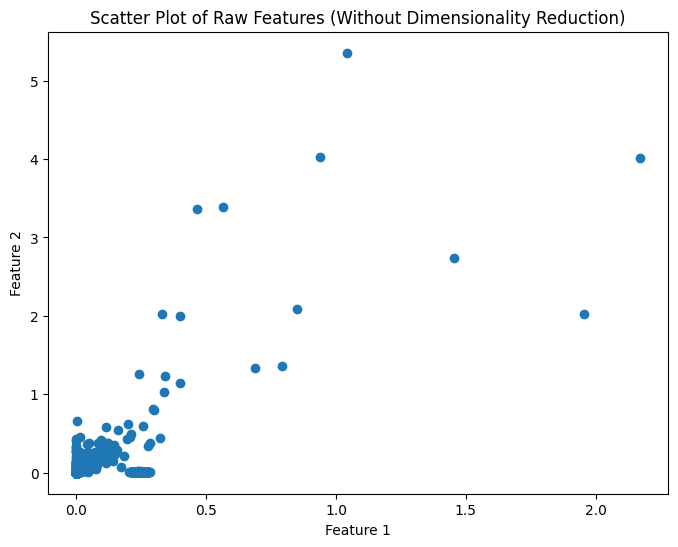

In [5]:
# scatter plot without dimensionality reduction
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

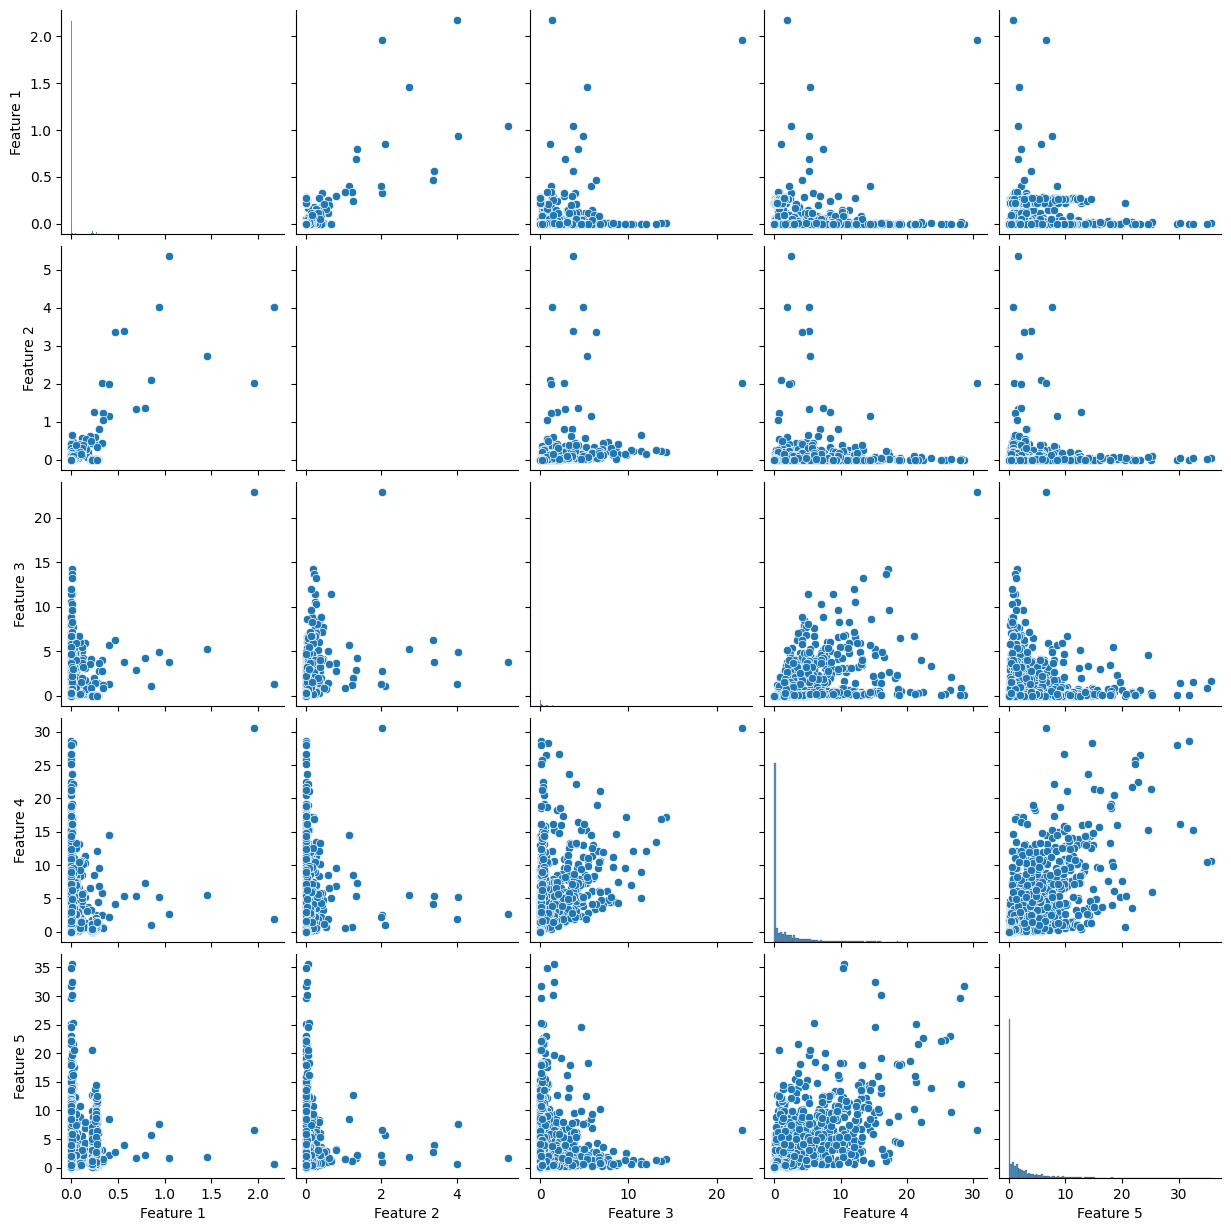

In [6]:
# Convert to DataFrame for pairplot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f"Feature {i}" for i in range(1, 6)])
sns.pairplot(df)
plt.show()

## **Why is dimensionality reduction important?**


From the experiments above, I noticed that the data points were densely packed and overlapping in some areas, especially near lower values, while others were widely scattered. This made it difficult to clearly identify distinct clusters. Another issue was that many feature values were clustered near zero, with only a few significantly larger ones, indicating a strong skew in the data distribution. Additionally, the pair plots showed non-linear relationships between features, making it harder to interpret patterns. Since the dataset contains many features, visualizing it without reducing dimensions was challenging. I also encountered the "Curse of Dimensionality," where high-dimensional data causes points to appear equally distant, making clustering less effective.

To overcome these issues, I will use dimensionality reduction techniques like PCA and t-SNE. These methods help project the data into a lower-dimensional space while keeping important patterns intact. PCA identifies and preserves the most significant variations in the data, while t-SNE is useful for visualizing complex, non-linear relationships between features. By reducing dimensions, clustering becomes more efficient and interpretable, making it easier to identify meaningful groups within the sound recordings.

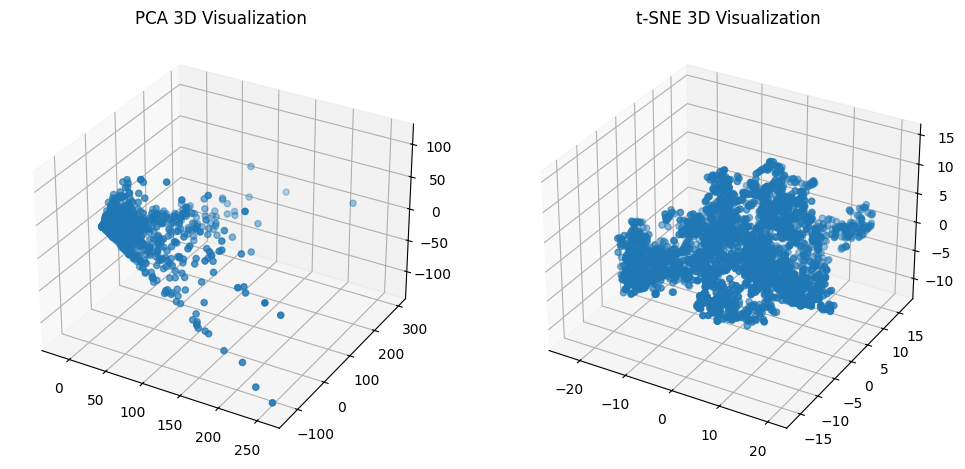

In [7]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
fig = plt.figure(figsize=(12, 6))

# PCA 3D Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2])
ax1.set_title("PCA 3D Visualization")

# t-SNE 3D Plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2])
ax2.set_title("t-SNE 3D Visualization")

plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

The **t-SNE plot** provides better separability of clusters compared to PCA because t-SNE captures non-linear relationships in high-dimensional data, making it more effective at distinguishing complex clusters. In your visualization, t-SNE shows more compact and well-separated groups, while PCA appears more spread out and less structured. This is because PCA is a linear method that maximizes variance but may merge clusters that are distinct in higher dimensions, whereas t-SNE preserves local similarities, leading to better cluster differentiation. Therefore, t-SNE is generally the better choice for visualizing clusters in complex datasets.

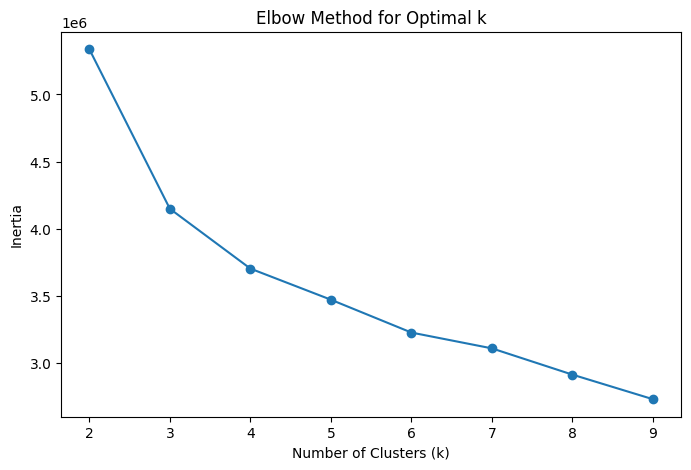

In [10]:
# Optimize number of clusters using Elbow Method
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

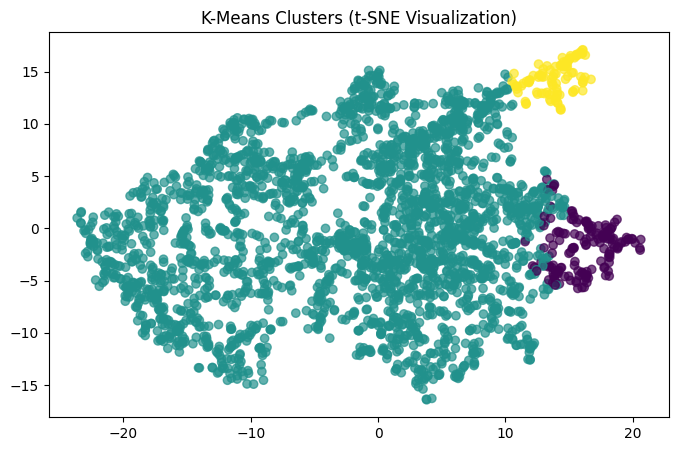

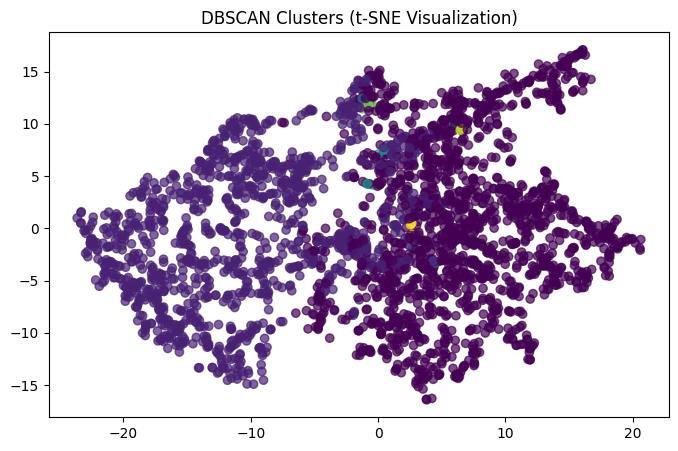

In [13]:
# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("K-Means Clusters (t-SNE Visualization)")
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.title("DBSCAN Clusters (t-SNE Visualization)")
plt.show()

In [17]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.7005, Davies-Bouldin Index: 1.0313
DBSCAN - Silhouette Score: -0.0305, Davies-Bouldin Index: 1.8554


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

K-Means outperforms DBSCAN based on the evaluation metrics, achieving a higher silhouette score (0.7808 vs. 0.0305) and a lower Davies-Bouldin index (1.0313 vs. 1.8954), indicating better-defined clusters. The t-SNE visualization shows K-Means producing more compact clusters, while DBSCAN struggles to form meaningful clusters, likely due to parameter sensitivity. DBSCAN's poor silhouette score suggests that points are not well assigned to clusters, possibly treating dense regions as noise. K-Means is more effective for this dataset, while DBSCAN may require fine-tuning for better performance.

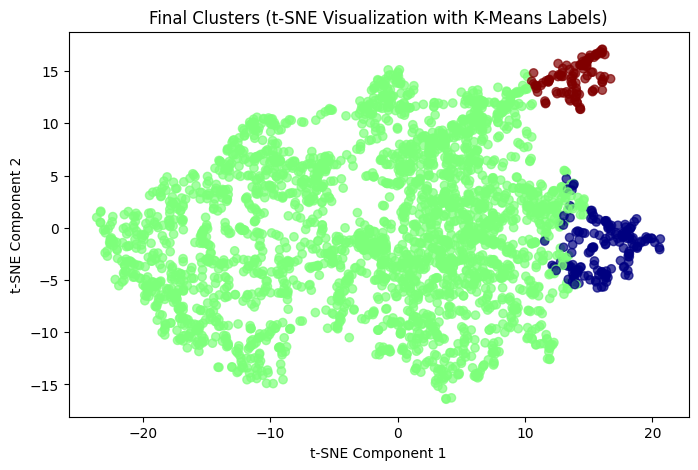

In [21]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='jet', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()

# Final Analysis
**- Explain why dimensionality reduction helped (or didn't) in clustering.**

Dimensionality reduction, specifically t-SNE, helped in visualizing the clusters but did not directly enhance clustering performance, as it prioritizes local relationships over global structure preservation. However, reducing high-dimensional data can improve clustering by eliminating noise and redundant features, leading to more efficient and interpretable results.

**- Justify why certain clustering methods worked better.**

K-Means outperformed DBSCAN, as shown by its higher silhouette score (0.7005 vs. -0.0305) and well-defined clusters in the t-SNE visualization. The Elbow Method confirmed an optimal k-value (≈3), reinforcing K-Means’ effectiveness. DBSCAN struggled due to its sensitivity to parameter tuning and failed to identify meaningful clusters, grouping most points into one category. K-Means worked better because its centroid-based approach suited the dataset’s globular cluster structure.

**- Relate findings to real-world clustering challenges.**

Real-world clustering challenges highlight the importance of choosing the right algorithm based on dataset structure. DBSCAN excels in anomaly detection and irregular clusters, like fraud detection, but struggles with dense, overlapping data. K-Means, though simple, works well for well-separated clusters, making it useful for market segmentation and recommendation systems. Understanding these differences is crucial for effective real-world applications.





